## 1. Load voxel model

In [5]:
from setup.voxel_setup import setup_voxel_scene, NUM_XYZ
from common.plot import Plotter
from simulation.simulator import get_irrad_loc_dir, compute_ior_gradient

import taichi as ti
# from scipy import ndimage

%load_ext autoreload
%autoreload 2
# May comment it because the compatibility of this extension is not good
%matplotlib widget 
import numpy as np

# debug=True to check boundary access
ti.init(arch=ti.gpu)

scene, floor_height = setup_voxel_scene()

sampler_multiplier = 6
to_load_save = True
plotter = Plotter(sampler_multiplier, floor_height)

GAUSSIAN_SIGMA = 2.0
GAUSSIAN_RADIUS = 2

scene.apply_filter(sigma=GAUSSIAN_SIGMA, radius=GAUSSIAN_RADIUS)
scene.gradient = compute_ior_gradient(scene.ior)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[Taichi] Starting on arch=cuda
Loaded Voxel shape: (128, 128, 128)  from: ./assets/bun_zipper_res3.ply
Number of filled voxels: 54575
Loaded Voxel shape: (128, 128, 128)  from: ./assets/wine_glass.obj
Number of filled voxels: 37518
Floor Ratio: -0.9 , Floor Height: 6


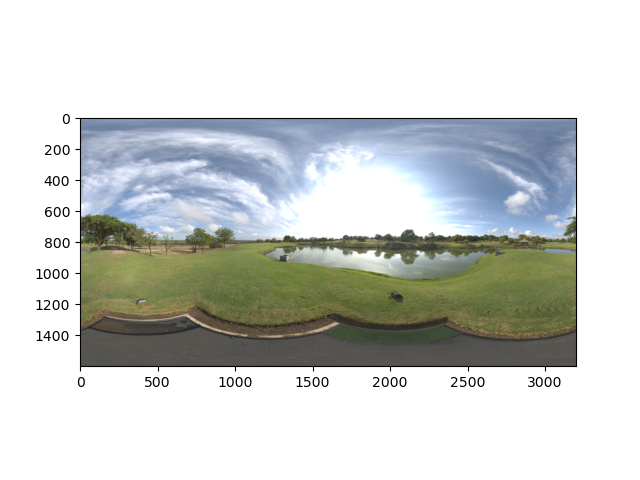

(1600, 3200, 3)
0.05882353 1.0


In [17]:
hdr_image = ti.tools.imread('assets/limpopo_golf_course_3k.hdr').astype('float32') / 255.0

import matplotlib.pyplot as plt
transposed_img = np.transpose(hdr_image, (1, 0, 2))[::-1, :, :]
plt.imshow(transposed_img)
plt.show()
print(transposed_img.shape)
print(transposed_img.min(), transposed_img.max())

## 2. Perform light simulation

In [6]:
scene.irradiance, scene.local_diretion = get_irrad_loc_dir(scene, sampler_multiplier, 
                                                           to_load_save=to_load_save, 
                                                           plotter=plotter,
                                                           num_show_images=3)
scene.truncate_outside_surface(gradient_threshold=0.06) # Post process the scene

[ Loaded ] irradiance and local direction from c:\Users\yaozi\Desktop\Voxel-Render\data\saves\NP(irrad,loc_dir)(6-samplers).npz


In [7]:
# plotter.plot_irradiance_grid(scene.irradiance)
# plotter.plot_irradiance_slices(scene.irradiance, num_slices=4, z_start=30, z_end=100)
# plotter.plot_local_direction_grid_slices(scene.local_diretion[:, floor_height:, :], num_slices=4, z_start=30, z_end=100)

## 3. Ray marching render

In [12]:
res = scene.offline_render([np.array([3.0, 3.0, 0.0])])
import matplotlib.pyplot as plt
plt.imshow(res[0])
plt.show()

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
scene.rt_render()

## 4. Different data structures to store or fit irradiance

In [ ]:
from data.siren import SirenFitter, siren_post_process
from data.mlp import MLP, mlp_post_process
from data.octree import Octree, octree_post_process

### 4.1 SIREN to fit irradiance

In [ ]:
siren_fitter= SirenFitter(scene.irradiance, floor_height, sampler_multiplier,
                     hidden_features=256, hidden_layers=3, omega=24)
siren_fitter.fit(total_epochs=24, batch_size=20000, lr=5e-4)

In [ ]:
siren_res = siren_fitter.infer()
plotter.plot_irradiance_slices(siren_res, threshold=3, num_slices=4, z_start=30, z_end=100)
siren_res.shape

In [ ]:
corrected_siren_res = siren_post_process(siren_res, gamma=0.2)
plotter.plot_irradiance_slices(corrected_siren_res, threshold=3, num_slices=4, z_start=30, z_end=100)

In [ ]:
assert corrected_siren_res.shape == scene.irradiance.shape, "The shape of the corrected siren result should be the same as the original irradiance grid"
scene.irradiance = corrected_siren_res
scene.rt_render()

### 4.2 MLP to fit irradiance

In [ ]:
mlp = MLP(scene.irradiance, floor_height, NUM_XYZ, sampler_multiplier, num_epoches=150)

In [ ]:
# Visualize the predicted irradiance field
mlp_predicted_irradiance = mlp.predict(pad=True)
plotter.plot_irradiance_slices(mlp_predicted_irradiance, threshold=3, 
                               num_slices=4, z_start=30, z_end=100)

In [ ]:
corrected_mlp_res = mlp_post_process(mlp_predicted_irradiance, None)
plotter.plot_irradiance_slices(corrected_mlp_res, threshold=3, num_slices=4, z_start=30, z_end=100)

In [ ]:
assert corrected_mlp_res.shape == scene.irradiance.shape, "The shape of the corrected mlp result should be the same as the original irradiance grid"
scene.irradiance = corrected_mlp_res
scene.rt_render()

### 4.3 Octree to store irradiance

In [ ]:
octree = Octree(threshold=14)
octree.construct(scene.irradiance)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {scene.irradiance.nbytes} bytes")
octree.visualize(plotter, num_slices=4, z_start=30, z_end=100)

In [ ]:
octree_res = octree.init_empty_grid()
octree.fill_grid(octree.root, octree_res, 0, 0, 0, octree.grid_size)
plotter.plot_irradiance_slices(octree_res, threshold=3, num_slices=4, z_start=30, z_end=100)

In [ ]:
corrected_octree_res = octree_post_process(octree_res)
plotter.plot_irradiance_slices(corrected_octree_res, threshold=3, num_slices=4, z_start=30, z_end=100)

In [ ]:
assert corrected_octree_res.shape == scene.irradiance.shape, "The shape of the corrected octree result should be the same as the original irradiance grid"
scene.irradiance = corrected_octree_res
scene.rt_render()

In [ ]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value